In [2]:
# https://www.kaggle.com/c/m5-forecasting-accuracy/data
# !kaggle competitions download -c m5-forecasting-accuracy

 98%|█████████████████████████████████████▎| 45.0M/45.8M [00:04<00:00, 11.5MB/s]
100%|██████████████████████████████████████| 45.8M/45.8M [00:04<00:00, 10.3MB/s]


In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns

MAX_ROWS = 500
make_path = lambda file: os.path.join('data', file)

### We want to predict item sales at stores 

- calendar.csv - Contains information about the dates on which the products are sold.

- sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]

- sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.

- sell_prices.csv - Contains information about the price of the products sold per store and date.

- sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

calendar.csv

I believe the date - as a number, does not truly influence buying habits. However, birthdays, events and commemorative dates sure influence buying habits: we need a way to code this into the model. 

- wday
- season (by date)
- event_name_1
- event_type_1

sales

- id is not important as it's one for each row
- item_id will give us the price of each product: does the price influences buying habits? Because we want to know sales **for each** item, knowing it's dept_id or category won't give us more information - however, for viz it might be interesting to plot by dept, for example.
- store_id will be important as we want to predict sales per store

We have 1947 - (10 - 4)  = 1941 days of data and want to predict 2 * 28 = 56 days ~ 1941/56 = 34.66

sell_prices

- prices vary by date, thus we need to link those things

## Data Importing 

In [4]:
os.listdir('data')

['sales_train_evaluation.csv',
 'calendar.csv',
 'sell_prices.csv',
 'sales_train_validation.csv',
 'sample_submission.csv']

In [5]:
gb_key = 'store_id'

In [6]:
df_calendar = pd.read_csv(
    make_path('calendar.csv'), 
)
df_sales = pd.read_csv(
    make_path('sales_train_evaluation.csv'), 
#     nrows = MAX_ROWS
)
print(f'Imported {df_sales.shape}')

Imported (30490, 1947)


## Data Merge

- We don't need to clean this dataset because it is already clean

In [7]:
df = df_sales.drop(columns = ['id',])

In [16]:
gb = df.groupby(by = gb_key, as_index = False)
groups = df[gb_key].unique()

In [39]:
df_test = gb.get_group(groups[0]).copy()

In [38]:
days = df.columns[df.columns.str.startswith('d_')]
# df_test[days] = df_test[days].sum(axis = 0).astype(np.uint8)

ValueError: Must have equal len keys and value when setting with an iterable

### Merge with prices

In [51]:
# dict like (store_id, item_id, wm_yr_wk = d + 11100) -> price
if False:
    d_prices = pd.read_csv(
        make_path('sell_prices.csv')
    ).set_index(
        [gb_key, 'item_id', 'wm_yr_wk']
    ).sell_price.to_dict()

## Data Viz

Let's plot sales for each day per location

In [40]:
agg_cat = df_test.groupby(by = 'cat_id').agg({d: np.sum for d in days})

In [41]:
agg_cat.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
cat_id,,,,,,,,,,,,,,,,,,,,,
FOODS,3239,3137,2008,2258,2032,2407,2693,3962,3418,2446,...,3365,4046,4717,3198,2794,2816,2854,2993,3783,4327
HOBBIES,556,498,415,392,268,467,346,769,432,384,...,588,806,687,417,393,381,406,539,719,646
HOUSEHOLD,542,520,393,401,330,402,411,706,490,327,...,998,1393,1303,953,762,798,876,901,1262,1316


In [32]:
agg_cat.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
cat_id,,,,,,,,,,,,,,,,,,,,,
FOODS,509.0,471.0,419.0,437.0,405.0,434.0,446.0,495.0,480.0,450.0,...,873.0,927.0,977.0,858.0,797.0,769.0,802.0,816.0,915.0,926.0
HOBBIES,118.0,98.0,87.0,87.0,82.0,101.0,93.0,130.0,98.0,87.0,...,224.0,249.0,247.0,189.0,172.0,165.0,196.0,208.0,244.0,238.0
HOUSEHOLD,210.0,209.0,175.0,176.0,171.0,182.0,198.0,242.0,191.0,164.0,...,460.0,534.0,523.0,445.0,365.0,424.0,437.0,446.0,506.0,526.0


<IPython.core.display.Javascript object>


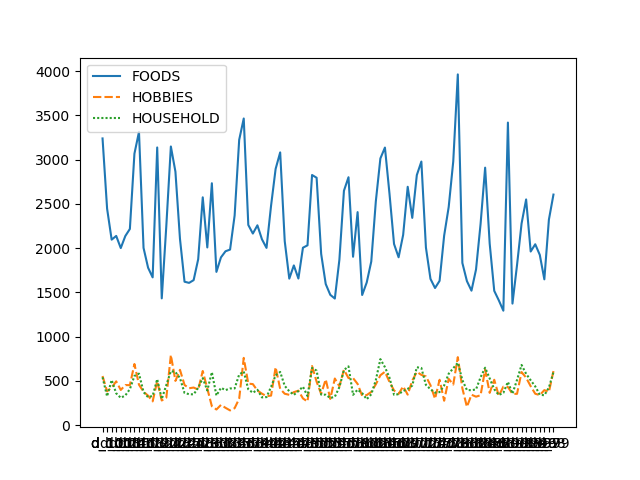

In [42]:
sns.lineplot(data = agg_cat[days[:100]].T)

## Feature Engineering 

We will make a classification instead of trying to predict how many items, we want to know if anything was sold, at first

## Model Training and Evaluation

## Results